<a href="https://colab.research.google.com/github/thatguyandy27/DLWithPython/blob/main/chapter9/Chapter9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the code from kaggle.

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

 99% 808M/812M [00:05<00:00, 193MB/s]
100% 812M/812M [00:05<00:00, 154MB/s]


In [3]:
!unzip -qq dogs-vs-cats.zip

In [4]:
!unzip -qq train.zip

Splitting the images into datasets

In [5]:
import os, shutil, pathlib

In [6]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [7]:
def make_subset(subset_name, start_index, end_index):
  # for cat and dog
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    # filename is cat/dog.number.jpg
    fnames = [f"{category}.{i}.jpg"
              for i in range(start_index, end_index)]
    
    # for each file copy 
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)

  


In [8]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Building the model.  Data is in train/test/validation folders under cat/dog folders.

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1. / 255) (x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)

  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="mini-xception.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [20]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [17]:

train_dataset = image_dataset_from_directory( new_base_dir / "train", image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory( new_base_dir / "validation", image_size=(180, 180), batch_size= 32)
test_dataset = image_dataset_from_directory( new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [21]:
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 32s 449ms/step - loss: 0.7359 - accuracy: 0.5675 - val_loss: 0.7008 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 28s 436ms/step - loss: 0.6609 - accuracy: 0.6055 - val_loss: 0.6929 - val_accuracy: 0.4990
Epoch 3/100
63/63 [==============================] - 28s 430ms/step - loss: 0.6403 - accuracy: 0.6340 - val_loss: 0.6930 - val_accuracy: 0.5090
Epoch 4/100
63/63 [==============================] - 27s 431ms/step - loss: 0.6158 - accuracy: 0.6580 - val_loss: 0.6967 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 27s 415ms/step - loss: 0.6051 - accuracy: 0.6775 - val_loss: 0.7143 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 27s 429ms/step - loss: 0.5790 - accuracy: 0.6990 - val_loss: 0.7621 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 28s 433ms/step - loss: 0.5606 - accuracy: 0.7035 - val_loss: 0.7896 - val_accuracy:

In [22]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)


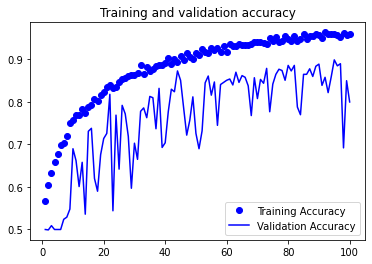

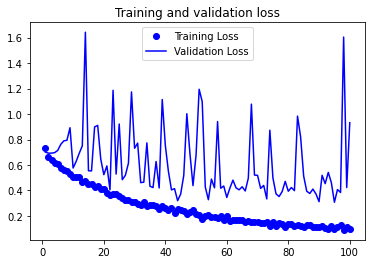

In [23]:
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


In [24]:
#test accuracy
test_model = keras.models.load_model("mini-xception.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)


63/63 [==============================] - 4s 42ms/step - loss: 0.4182 - accuracy: 0.8875


In [25]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.887
